# Code for "Parsing 1.2 million Jupyter Notebooks" video 

* Download files on `https://library.ucsd.edu/dc/collection/bb6931851t`

### Imports

In [ ]:
import ast
import io
import inspect
import itertools
import matplotlib.pyplot as plt
import nbformat
import operator
import pandas
import pickle
import plotly.express as px
import seaborn as sns
import zipfile

from collections import Counter
from pathlib import Path
from IPython.core.inputtransformer2 import TransformerManager
from joblib import Parallel, delayed
from typing import List

import plotly.io as pio
pio.templates.default = "simple_white"

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Extract notebooks with Pandas in it from zip archives

### Utils

In [ ]:
def files_in_zip(p: Path) -> List[str]:
    zip_file = zipfile.ZipFile(p)
    return zip_file.namelist()

### Extracting notebooks

In [ ]:
input_folder = Path("path_to_all_zip_archives")
output_folder = Path("path_to_folder_with_extracted_notebooks")

In [ ]:
zip_files = list(input_folder.glob("./*.zip"))
all_nbs = [file for zip_file in zip_files for file in files_in_zip(zip_file)]

In [ ]:
# https://stackoverflow.com/questions/15282651/how-do-i-read-text-files-within-a-zip-file
files_with_pandas = []
for path_to_zip in zip_files:
    with zipfile.ZipFile(path_to_zip) as zip_file:
        path_to_nbs = zip_file.namelist()

        for path_to_nb in tqdm(path_to_nbs):
            with zip_file.open(path_to_nb) as zf:
                with io.TextIOWrapper(zf, encoding="utf-8") as nb_file:
                    for line in nb_file.readlines():
                        if "pandas" in line:
                            files_with_pandas.append((path_to_zip, path_to_nb))
                            break

In [ ]:
print(f"There are {100*len(files_with_pandas)/len(all_nbs):2f}% notebooks with 'Pandas' inside")

In [ ]:
it = itertools.groupby(files_with_pandas, operator.itemgetter(0))
for path_to_zip, sublist in it:
    nbs_to_extract = list(sublist)
    with zipfile.ZipFile(path_to_zip, 'r') as zip_file: 
        for path_to_nb in tqdm(nbs_to_extract):
            zip_file.extract(path_to_nb[1], output_folder) 

## 2. AST Parsing

### Utils

In [ ]:
def write_pickle(obj, path):
    with open(path, 'wb') as fh:
        pickle.dump(obj, fh)
        
def read_pickle(path):
    with (open(path, "rb")) as f:
        return pickle.load(f)

In [ ]:
def get_nb_code(path_nb: str) -> str:
    d = nbformat.read(path_nb, as_version=4)
    
    code = "\n".join(
        [cell["source"] for cell in d.cells if cell["cell_type"] == "code"]
    )
    code = TransformerManager().transform_cell(code)
    return code

In [ ]:
def parse_nb(path_nb):
    try:
        code = get_nb_code(path_nb)
    except:
        return [{"error": "Parsing notebook"}]
    try:
        tree = ast.parse(code)
    except:
        return [{"error": "Parsing AST"}]
    
    res = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            for alias in node.names:
                res.append({"from": None, "name": alias.name, "as": alias.asname})

        if isinstance(node, ast.ImportFrom):
            for alias in node.names:
                res.append({"from": node.module, "name": alias.name, "as": alias.asname})
        
        if isinstance(node, ast.Attribute):
            if isinstance(node.value, ast.Name):
                res.append({"from": node.value.id, "call": node.attr})
                
        if isinstance(node, ast.Call):
            if isinstance(node.func, ast.Name):
                res.append({"from": "", "call": node.func.id})
                
            elif isinstance(node.func, ast.Attribute):
                if isinstance(node.func.value, ast.Name):
                    res.append({"from": node.func.value.id, "call": node.func.attr})
                #else: 
                    #res.append({"type": type(node.func.value)})
            #else: 
                #res.append({"type": type(node.func)})
    return res

In [ ]:
def save_plotly(data, filename):
    fig = px.bar(
        x=[c[0] for c in data],
        y=[c[1] for c in data],
        height=2160,
        width=3840,
    )
    fig.update_xaxes(
        title_font = {"size": 28, "family": "Verdana"},
        title_standoff = 28*2,
        title_text ="Pandas calls",
        tickfont=dict(family='Source Code Pro', size=28),
    )
    fig.update_yaxes(
        title_font = {"size": 28, "family": "Verdana"},
        title_standoff = 28*2,
        title_text ="Notebook appearances",
        tickfont=dict(family='Source Code Pro', size=28)
    )
    fig.write_image(filename)

### Parsing all notebooks

In [ ]:
folder = Path("path_to_folder_with_extracted_notebooks")
all_nb_paths = list(folder.glob("./*.ipynb"))

In [ ]:
# all_info_nest = [parse_nb(p) for p in tqdm(all_nb_paths)]  # this takes too long
all_info_nest = Parallel(n_jobs=9)(delayed(parse_nb)(p) for p in tqdm(all_nb_paths))   # multicore version
write_pickle(all_info_nest, "all_info_nest.pkl")

In [ ]:
all_info = [info_list for info_list in all_info_nest if not any("error" in ele for ele in info_list)]

In [ ]:
final_info = [
    info_list
    for info_list in all_info 
    if len({f"{i.get('name')}.{i.get('as')}" for i in info_list if i.get("name")=="pandas"})==1
]

### How many were parsed correctly?

In [ ]:
Counter([not any("error" in ele for ele in info_list) for info_list in all_info_nest])

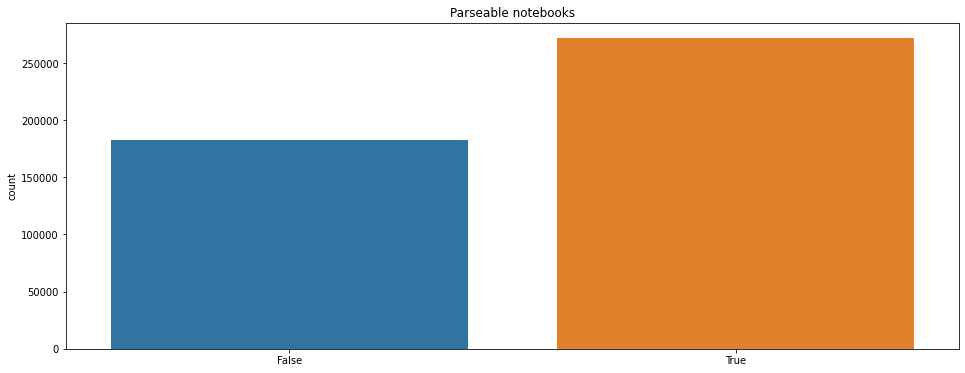

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))

ax.set_title("Parseable notebooks")
ax = sns.countplot([not any("error" in ele for ele in info_list) for info_list in all_info_nest])
fig.show()

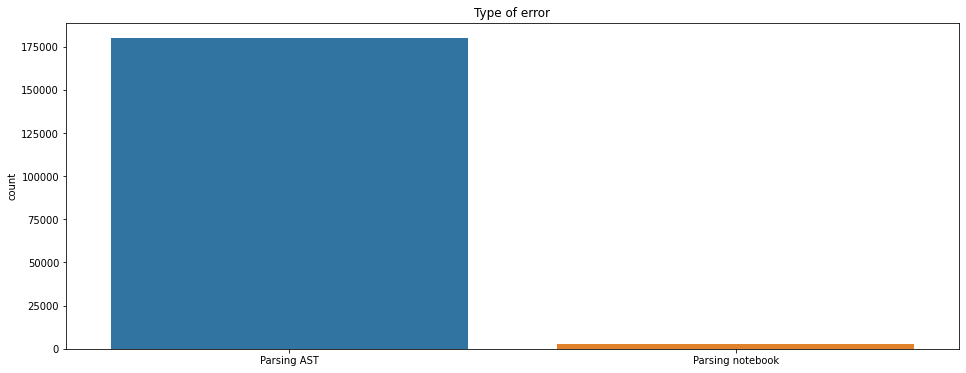

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))

ax.set_title("Type of error")
ax = sns.countplot([info_list[0].get("error") for info_list in all_info_nest if any("error" in ele for ele in info_list)])
fig.show()

### What Pandas aliases are used?

In [ ]:
Counter(
    [
        info.get("as")
        for info_list in all_info 
        for info in info_list
        if info.get("name")=="pandas"
    ]
)

Counter({None: 11268,
         'pd': 264032,
         'pan': 21,
         'pds': 70,
         'py': 4,
         'pnd': 82,
         'p': 99,
         'PD': 8,
         'adorable': 1,
         'pn': 72,
         'pda': 8,
         'pa': 57,
         'ps': 93,
         'panda': 13,
         'pandas': 33,
         'np': 14,
         'arquivo': 2,
         'bib': 8,
         'pd2': 1,
         'PANDAS': 6,
         'pp': 1,
         'pt': 1,
         'df': 2,
         'Pd': 1,
         'dataframe': 2,
         'teddy': 2,
         'pdf': 1,
         'pandu': 4,
         '_pnd': 4,
         'pdn': 1,
         'pf': 3,
         'apd': 1,
         'pand': 1,
         'P': 1,
         'pdbear': 1,
         'pdSeries': 1,
         'px': 1,
         'od': 1,
         'pdusers': 1,
         'pdmovies': 3,
         'pdratings': 2,
         'pb': 3,
         'pdp': 2,
         'pdm': 1,
         'ds': 2,
         'dp': 2,
         'pnds': 4,
         'pdr7': 1,
         'stock': 1,
         'ph': 1

### Are people changing pandas aliases midway?

In [ ]:
Counter([
    len({f"{i.get('name')}.{i.get('as')}" for i in info_list if i.get("name")=="pandas"})
    for info_list in all_info
    
]).most_common(20)

[(1, 253315), (0, 17392), (2, 977), (3, 2)]

- 0 = probably pandas in markdown
- 2/3 = yes there are, less than 1000 on 200_000, let's just remove them

## 3. Counting Pandas calls

### Top level calls

We only count distinct calls per notebook. If 10 pd.Dataframe in notebook, only counts as one

In [ ]:
def find_top_level_calls(arr):
    def compute_alias(d):
        top_level_alias = list({i.get('as') for i in d if i.get("name")=="pandas"})[0]
        if top_level_alias is None:
            top_level_alias = "pandas"
        return top_level_alias
        
    aliases = [compute_alias(info_list) for info_list in arr]
    
    res = [
        imp
        for alias, info_list in zip(aliases, arr)
        for imp in {i.get("call") for i in info_list if i.get("from")==alias and "call" in i}
    ]
        
    return res

In [ ]:
top_level_counts = Counter(
    find_top_level_calls(final_info)
).most_common(10)
top_level_counts

[('read_csv', 146753),
 ('DataFrame', 101974),
 ('concat', 34973),
 ('Series', 24485),
 ('to_datetime', 19266),
 ('merge', 15445),
 ('get_dummies', 14061),
 ('set_option', 11247),
 ('read_excel', 9359),
 ('read_table', 6723)]

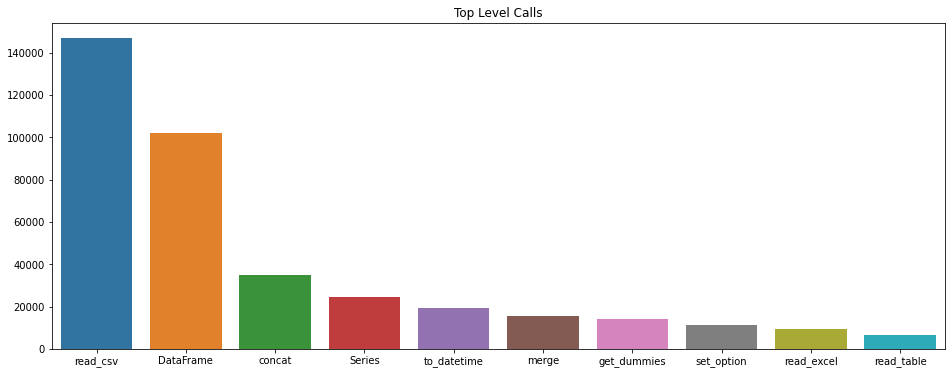

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))

ax.set_title("Top Level Calls")
ax = sns.barplot(
    x=[c[0] for c in top_level_counts],
    y=[c[1] for c in top_level_counts],
)
fig.savefig("top_level.png")
fig.show()

In [ ]:
save_plotly(top_level_counts, "top_level.svg")

### Compare calls to list of members in inspected Pandas/DataFrame

In [ ]:
inspect.getmembers(pandas, predicate=inspect.isclass)

[('BooleanDtype', pandas.core.arrays.boolean.BooleanDtype),
 ('Categorical', pandas.core.arrays.categorical.Categorical),
 ('CategoricalDtype', pandas.core.dtypes.dtypes.CategoricalDtype),
 ('CategoricalIndex', pandas.core.indexes.category.CategoricalIndex),
 ('DataFrame', pandas.core.frame.DataFrame),
 ('DateOffset', pandas._libs.tslibs.offsets.DateOffset),
 ('DatetimeIndex', pandas.core.indexes.datetimes.DatetimeIndex),
 ('DatetimeTZDtype', pandas.core.dtypes.dtypes.DatetimeTZDtype),
 ('ExcelFile', pandas.io.excel._base.ExcelFile),
 ('ExcelWriter', pandas.io.excel._base.ExcelWriter),
 ('Flags', pandas.core.flags.Flags),
 ('Float32Dtype', pandas.core.arrays.floating.Float32Dtype),
 ('Float64Dtype', pandas.core.arrays.floating.Float64Dtype),
 ('Float64Index', pandas.core.indexes.numeric.Float64Index),
 ('Grouper', pandas.core.groupby.grouper.Grouper),
 ('HDFStore', pandas.io.pytables.HDFStore),
 ('Index', pandas.core.indexes.base.Index),
 ('Int16Dtype', pandas.core.arrays.integer.Int16

In [ ]:
all_pandas_methods = [func[0] for func in inspect.getmembers(pandas, predicate=inspect.isfunction) if not func[0].startswith("__")]
all_pandas_members = [func[0] for func in inspect.getmembers(pandas) if not func[0].startswith("__")]

In [ ]:
all_dataframe_methods = [func[0] for func in inspect.getmembers(pandas.DataFrame, predicate=inspect.isfunction) if not func[0].startswith("_")]
all_dataframe_members = [func[0] for func in inspect.getmembers(pandas.DataFrame) if not func[0].startswith("_")]

In [ ]:
def find_pandas_method_calls(arr):    
    res = [
        imp
        for info_list in arr
        for imp in {i.get("call") for i in info_list if "call" in i and i.get("call") in all_pandas_methods}
    ]
    return res

In [ ]:
def find_pandas_calls(arr):    
    res = [
        imp
        for info_list in arr
        for imp in {i.get("call") for i in info_list if "call" in i and i.get("call") in all_pandas_members}
    ]
    return res

In [ ]:
def find_dataframe_method_calls(arr):    
    res = [
        imp
        for info_list in arr
        for imp in {i.get("call") for i in info_list if "call" in i and i.get("call") in all_dataframe_methods}
    ]
    return res

In [ ]:
def find_dataframe_calls(arr):    
    res = [
        imp
        for info_list in arr
        for imp in {i.get("call") for i in info_list if "call" in i and i.get("call") in all_dataframe_members}
    ]
    return res

In [ ]:
def final_answer(arr):    
    all_m = [i for i in all_dataframe_members + all_pandas_members] # if i not in ["unique", ""]]
    res = [
        imp
        for info_list in arr
        for imp in {i.get("call") for i in info_list if "call" in i and i.get("call") in all_m}
    ]
    return res

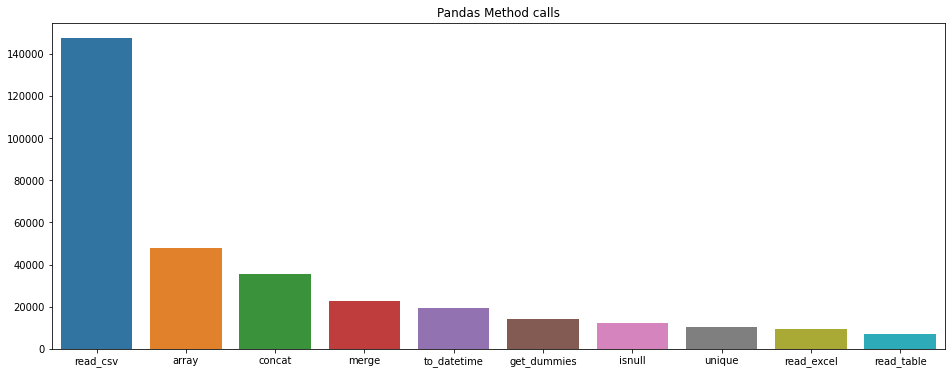

In [ ]:
pd_level_method_counts = Counter(
    find_pandas_method_calls(final_info)
).most_common(10)

fig, ax = plt.subplots(figsize=(16,6))

ax.set_title("Pandas Method calls")
ax = sns.barplot(
    x=[c[0] for c in pd_level_method_counts],
    y=[c[1] for c in pd_level_method_counts],
)
fig.show()

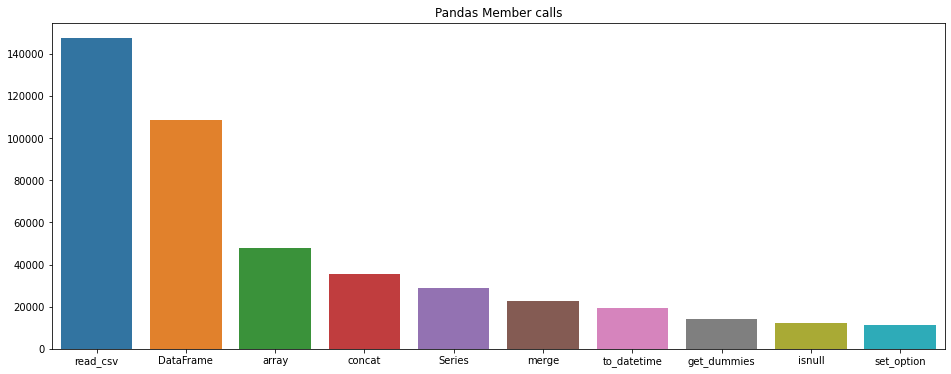

In [ ]:
pd_level_member_counts = Counter(
    find_pandas_calls(final_info)
).most_common(10)

fig, ax = plt.subplots(figsize=(16,6))

ax.set_title("Pandas Member calls")
ax = sns.barplot(
    x=[c[0] for c in pd_level_member_counts],
    y=[c[1] for c in pd_level_member_counts],
)
fig.show()

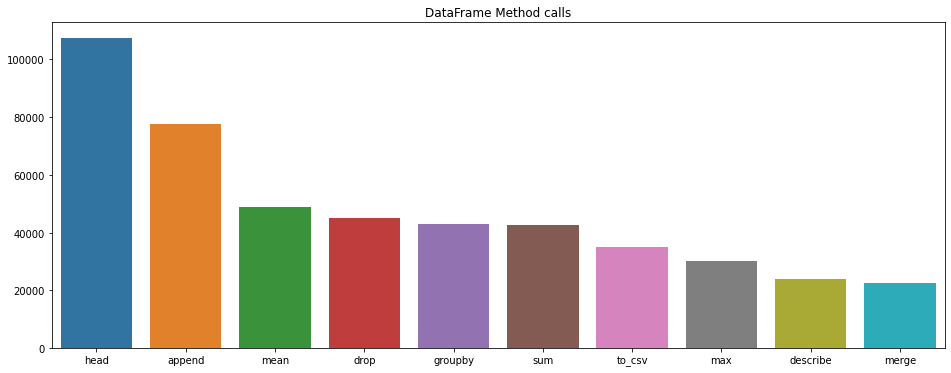

In [ ]:
df_level_method_counts = Counter(
    find_dataframe_method_calls(final_info)
).most_common(10)

fig, ax = plt.subplots(figsize=(16,6))

ax.set_title("DataFrame Method calls")
ax = sns.barplot(
    x=[c[0] for c in df_level_method_counts],
    y=[c[1] for c in df_level_method_counts],
)
fig.show()

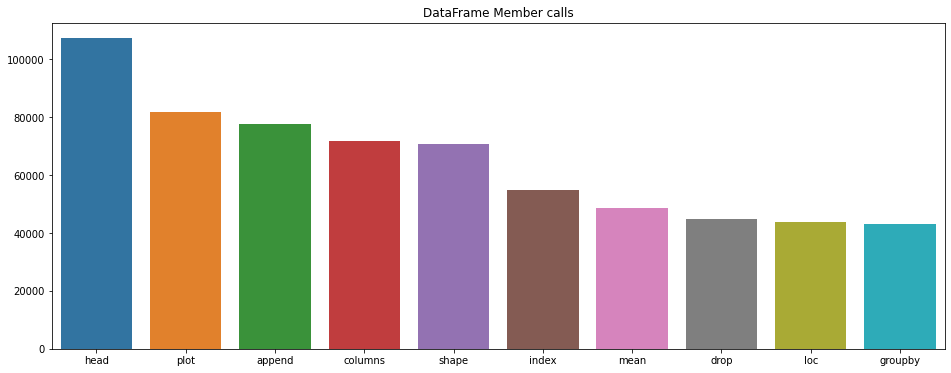

In [ ]:
df_level_counts = Counter(
    find_dataframe_calls(final_info)
).most_common(10)

fig, ax = plt.subplots(figsize=(16,6))

ax.set_title("DataFrame Member calls")
ax = sns.barplot(
    x=[c[0] for c in df_level_counts],
    y=[c[1] for c in df_level_counts],
)
fig.show()

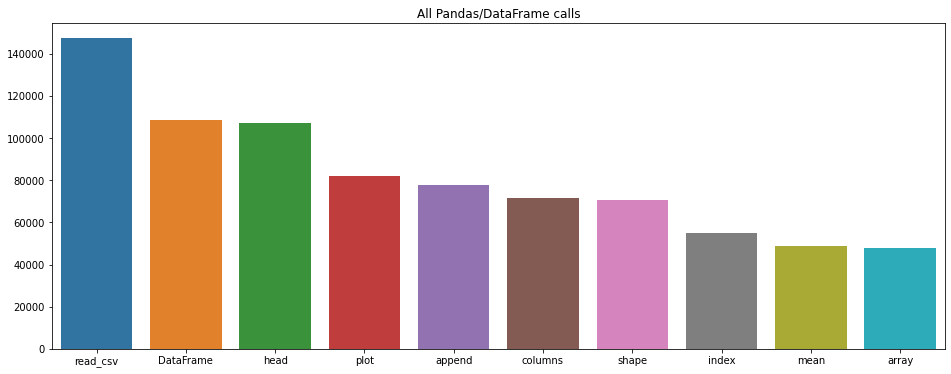

In [ ]:
this_is_it = Counter(
    final_answer(final_info)
).most_common(10)

fig, ax = plt.subplots(figsize=(16,6))

ax.set_title("All Pandas/DataFrame calls")
ax = sns.barplot(
    x=[c[0] for c in this_is_it],
    y=[c[1] for c in this_is_it],
)
fig.show()

In [ ]:
save_plotly(df_level_counts, "df_level.svg")
save_plotly(df_level_method_counts, "df_level_methods.svg")
save_plotly(this_is_it, "this_is_it.svg")